In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aux_functions as aux

sns.set_theme()

In [2]:
df = pd.read_csv('../data.csv')
print('Amostras: {} \nColunas: {}'.format(df.shape[0], df.shape[1]))

Amostras: 880 
Colunas: 53


### Provando a precisão da velocidade obtida pelo FFT do tacômetro

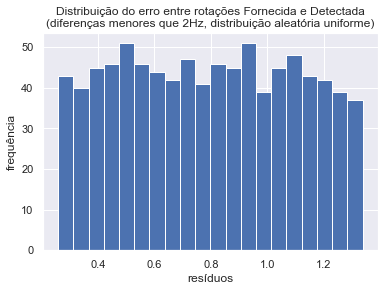

In [3]:
# distribuição do erro
plt.hist(df['rotacao']-df['fundamental'],20)
plt.title('Distribuição do erro entre rotações Fornecida e Detectada'+ 
          '\n(diferenças menores que 2Hz, distribuição aleatória uniforme)')
plt.xlabel('resíduos')
plt.ylabel('frequência')
plt.show()

# remove coluna de 'rotacao', que é redundante con 'fundamental'
df.pop('rotacao');

In [4]:
# mapeia velocidade em intervalos decimais
decimals = (pd.cut(df['fundamental'], bins=[0,15,25,35,45,55,65], labels=False)+1)*10
df.insert(3, 'fundamental_aprox', decimals)

# Organizando as features por categoria e por eixo

In [5]:
# mapeia cada categoria de feature para suas instâncias
columns = list(df.columns)
feat_type = {
    'harmonico 1':  [col for col in columns if '1h' in col],
    'harmonico 2':  [col for col in columns if '2h' in col],
    'harmonico 3':  [col for col in columns if '3h' in col],
    'entropia':   [col for col in columns if 'entr' in col],
    'curtose':    [col for col in columns if 'kurt' in col],
    'media':      [col for col in columns if 'mean' in col],
    'RMS':         [col for col in columns if 'rms' in col],
    # 'descritivos': ['defeito', severidade, 'rotacao', 'fundamental'],
}

# faz o mapeamento inverso, do nome de cada feature para a sua categoria
feat_to_type = {v[i]: k for k, v in feat_type.items() for i in range(len(v))}

# mostra cada feature
listed =[]
for k,i in feat_type.items():
    k = k +': '
    print('{:>13}'.format(k), i)
    listed.extend(i)

# mosta todas as outras colunas
print('{:>13}'.format('descritivos: '), [i for i in df.columns if i not in listed])

harmonico 1:  ['ac1ax_1h', 'ac1rad_1h', 'ac1tg_1h', 'ac2ax_1h', 'ac2rad_1h', 'ac2tg_1h', 'microfone_1h']
harmonico 2:  ['ac1ax_2h', 'ac1rad_2h', 'ac1tg_2h', 'ac2ax_2h', 'ac2rad_2h', 'ac2tg_2h', 'microfone_2h']
harmonico 3:  ['ac1ax_3h', 'ac1rad_3h', 'ac1tg_3h', 'ac2ax_3h', 'ac2rad_3h', 'ac2tg_3h', 'microfone_3h']
   entropia:  ['ac1ax_entr', 'ac1rad_entr', 'ac1tg_entr', 'ac2ax_entr', 'ac2rad_entr', 'ac2tg_entr', 'microfone_entr']
    curtose:  ['ac1ax_kurt', 'ac1rad_kurt', 'ac1tg_kurt', 'ac2ax_kurt', 'ac2rad_kurt', 'ac2tg_kurt', 'microfone_kurt']
      media:  ['ac1ax_mean', 'ac1rad_mean', 'ac1tg_mean', 'ac2ax_mean', 'ac2rad_mean', 'ac2tg_mean', 'microfone_mean']
        RMS:  ['ac1ax_rms', 'ac1rad_rms', 'ac1tg_rms', 'ac2ax_rms', 'ac2rad_rms', 'ac2tg_rms', 'microfone_rms']
descritivos:  ['defeito', 'severidade', 'fundamental', 'fundamental_aprox']


In [6]:
# mapeia cada eixo de captação para suas instâncias
eixo = {
    'axial':     [col for col in columns if 'ax' in col],
    'radial':    [col for col in columns if 'rad' in col],
    'tangente':  [col for col in columns if 'tg' in col],
    'microfone': [col for col in columns if 'mic' in col],
}

# faz o mapeamento inverso, do nome de cada feature para o seu eixo
feat_to_eixo = {v[i]: k for k, v in eixo.items() for i in range(len(v))}

# mostra cada feature
listed =[]
for k,i in eixo.items():
    k = k +': '
    print('{:>11}'.format(k), i[:7], '\n           ', i[7:], '\n')
    listed.extend(i)

    axial:  ['ac1ax_1h', 'ac1ax_2h', 'ac1ax_3h', 'ac1ax_entr', 'ac1ax_kurt', 'ac1ax_mean', 'ac1ax_rms'] 
            ['ac2ax_1h', 'ac2ax_2h', 'ac2ax_3h', 'ac2ax_entr', 'ac2ax_kurt', 'ac2ax_mean', 'ac2ax_rms'] 

   radial:  ['ac1rad_1h', 'ac1rad_2h', 'ac1rad_3h', 'ac1rad_entr', 'ac1rad_kurt', 'ac1rad_mean', 'ac1rad_rms'] 
            ['ac2rad_1h', 'ac2rad_2h', 'ac2rad_3h', 'ac2rad_entr', 'ac2rad_kurt', 'ac2rad_mean', 'ac2rad_rms'] 

 tangente:  ['ac1tg_1h', 'ac1tg_2h', 'ac1tg_3h', 'ac1tg_entr', 'ac1tg_kurt', 'ac1tg_mean', 'ac1tg_rms'] 
            ['ac2tg_1h', 'ac2tg_2h', 'ac2tg_3h', 'ac2tg_entr', 'ac2tg_kurt', 'ac2tg_mean', 'ac2tg_rms'] 

microfone:  ['microfone_1h', 'microfone_2h', 'microfone_3h', 'microfone_entr', 'microfone_kurt', 'microfone_mean', 'microfone_rms'] 
            [] 



O primeiro procedimento é separar os conjuntos.

In [7]:
# conta número de samples para cada defeito
df['defeito'].value_counts()

desbalanceamento             333
desalinhamento_vertical      301
desalinhamento_horizontal    197
normal                        49
Name: defeito, dtype: int64

Será averiguada a relvância da normalização das variáveis em relação à velocidade de rotação de cada ensaio.

In [8]:
# gera cópia profunda para alterar os valores internos sem corromper originais
df_norm = df.copy(deep=True)

# normaliza cada um por 1/fundamental
df_norm.iloc[:, 4:] = df.iloc[:, 4:].div(df['fundamental'], axis=0)

In [9]:
df.query("defeito == 'desbalanceamento' or defeito == 'normal'")

,defeito,severidade,fundamental,fundamental_aprox,ac1ax_1h,ac1ax_2h,ac1ax_3h,ac1ax_entr,ac1ax_kurt,ac1ax_mean,...,ac2tg_kurt,ac2tg_mean,ac2tg_rms,microfone_1h,microfone_2h,microfone_3h,microfone_entr,microfone_kurt,microfone_mean,microfone_rms
498,desbalanceamento,10.0,13.6272,10,0.614861,1.106082,0.418113,1.875901,-0.792840,0.000727,...,-0.142961,0.039913,48.052180,0.799733,0.122876,0.545375,0.931364,-0.017502,0.014242,8.726840
499,desbalanceamento,10.0,14.2284,10,0.576935,1.100560,0.384907,1.864294,-0.869464,-0.000384,...,-0.293248,-0.019935,51.543861,0.701435,0.090301,0.716588,0.975597,-0.052881,0.017785,9.126381
500,desbalanceamento,10.0,15.4308,20,0.626585,1.283208,10.063108,1.875905,-0.614587,0.000001,...,-0.265470,0.116550,50.609899,0.623781,0.770836,3.682855,1.005433,0.144308,0.018686,9.562646
501,desbalanceamento,10.0,16.2324,20,0.447165,0.660919,14.666422,1.858617,-0.852201,0.002793,...,-0.364828,0.081646,45.340454,0.890845,0.781065,5.306885,0.936459,-0.345275,0.007922,8.856612
502,desbalanceamento,10.0,16.8336,20,0.699053,0.719289,8.075579,1.877898,-0.551936,0.000520,...,-0.724785,-0.061868,127.442876,0.685346,0.571099,2.912441,0.960440,0.118109,0.012908,9.110052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,normal,0.0,56.7132,60,8.838403,1.297042,1.337774,2.258668,-0.186800,-0.003228,...,0.186492,0.075598,34.372586,0.969506,0.344556,0.754797,1.482483,-0.548637,0.011843,14.837352
876,normal,0.0,57.5148,60,5.762020,1.228815,1.524934,2.280727,-0.255453,0.000019,...,0.061836,0.104439,39.727396,0.650271,0.457723,0.573945,1.480588,-0.444927,0.011869,14.927665
877,normal,0.0,58.3164,60,6.967257,0.805126,2.314882,2.312472,-0.141417,-0.002639,...,-0.099084,0.009523,50.332619,0.887276,0.387735,0.833546,1.494828,-0.487654,0.011551,15.210384
878,normal,0.0,59.1180,60,8.404527,1.887939,1.914943,2.340555,-0.008522,-0.000612,...,-0.587838,0.006272,58.233539,1.003894,0.428010,0.612072,1.486929,-0.501368,0.010627,15.112108


In [10]:
# separa cada tipo de defeito em um dataframe específico
df_desbal      =      df.query("defeito == 'desbalanceamento' or defeito == 'normal'")
df_des_ve      =      df.query("defeito == 'desalinhamento_vertical' or defeito == 'normal'")
df_des_ho      =      df.query("defeito == 'desalinhamento_horizontal' or defeito == 'normal'")

# cria dicionário que aponta o nome do defeito para o seu DataFrame
fault_to_df = {
    'desbalanceamento'         :   df_desbal,
    'desalinhamento_vertical'  :   df_des_ve,
    'desalinhamento_horizontal':   df_des_ho,
}


# repete as operações para df normalizado
df_desbal_norm = df_norm.query("defeito == 'desbalanceamento' or defeito == 'normal'")
df_des_ve_norm = df_norm.query("defeito == 'desalinhamento_vertical' or defeito == 'normal'")
df_des_ho_norm = df_norm.query("defeito == 'desalinhamento_horizontal' or defeito == 'normal'")

fault_to_normalized_df = {
    'desbalanceamento'         :   df_desbal_norm,
    'desalinhamento_vertical'  :   df_des_ve_norm,
    'desalinhamento_horizontal':   df_des_ho_norm,
}

In [11]:
# descarta a coluna 'defeito' de cada df, pois é informação redundante
for _, dfram in fault_to_df.items():
    dfram.pop('defeito')
for _, dfram in fault_to_normalized_df.items():
    dfram.pop('defeito')
    
fault_to_df['desalinhamento_vertical'].head()

,severidade,fundamental,fundamental_aprox,ac1ax_1h,ac1ax_2h,ac1ax_3h,ac1ax_entr,ac1ax_kurt,ac1ax_mean,ac1ax_rms,...,ac2tg_kurt,ac2tg_mean,ac2tg_rms,microfone_1h,microfone_2h,microfone_3h,microfone_entr,microfone_kurt,microfone_mean,microfone_rms
197,0.51,12.2244,10,1.314350,0.685271,6.799286,1.926756,0.012352,-0.001213,25.692180,...,-0.431925,-0.020623,62.391259,0.972488,0.390341,1.943040,1.006946,1.228098,0.020396,9.516448
198,0.51,12.8256,10,0.582629,1.103922,14.542427,1.896688,-0.452327,-0.000583,24.218310,...,0.093143,0.324467,66.245670,0.625937,0.506767,4.441556,0.888412,0.721683,0.011807,7.946951
199,0.51,14.6292,10,0.563533,3.935806,0.842566,1.896409,-0.564041,-0.000793,24.217983,...,-0.118386,-0.033993,88.370957,0.646703,1.384931,0.665266,0.953006,0.132800,0.018378,8.867801
200,0.51,15.8316,20,0.527811,14.141063,0.664993,1.908416,-0.470012,-0.002158,24.361031,...,-0.441469,-0.067903,62.329029,0.709394,4.423690,0.655683,0.889416,0.377087,0.012051,8.005840
201,0.51,16.6332,20,0.680303,10.055396,0.603452,1.899257,-0.297248,-0.001335,24.184495,...,-0.933410,0.165706,125.096834,0.821151,3.222073,0.543422,0.889839,0.281509,0.010640,8.054550


# Análise de correlação

## Desbalanceamento

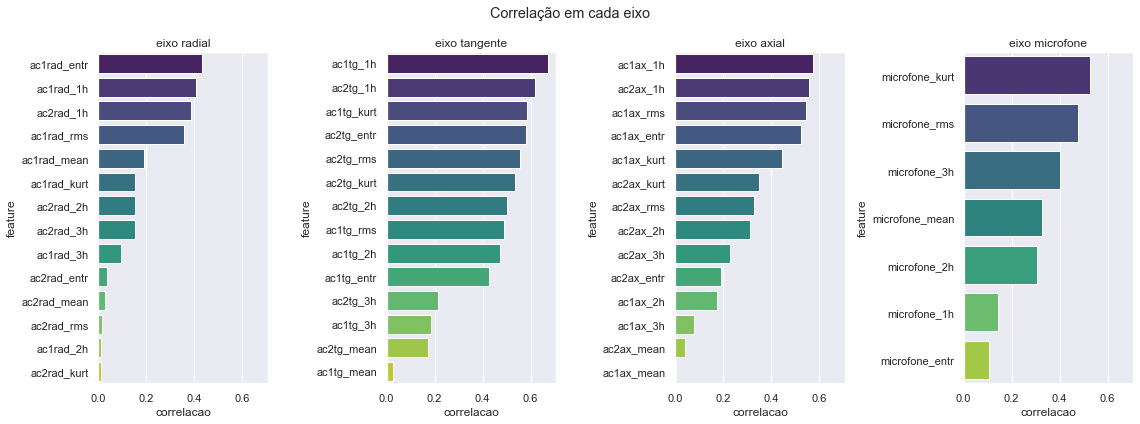

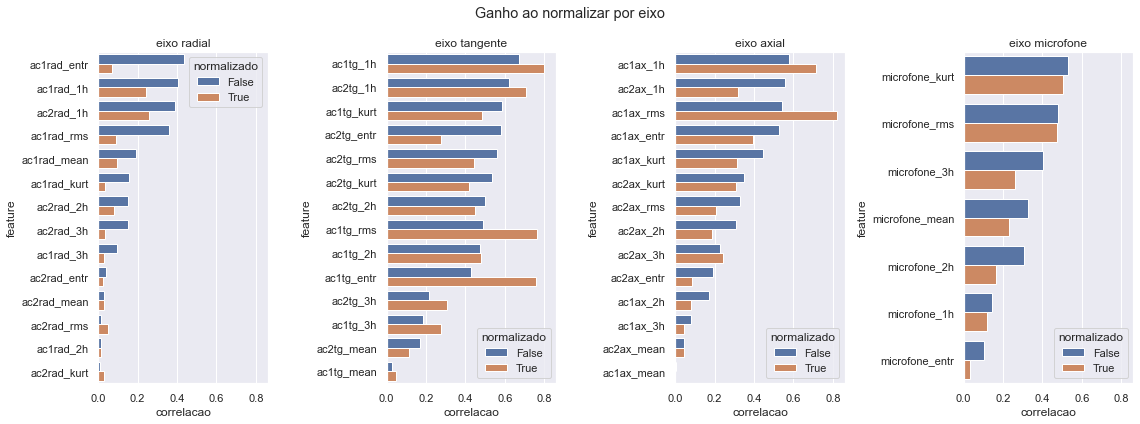

In [12]:
corr_df = aux.gera_corr_df('desbalanceamento', df_desbal, df_desbal_norm, feat_to_eixo, feat_to_type)

aux.plot_correlations(corr_df)

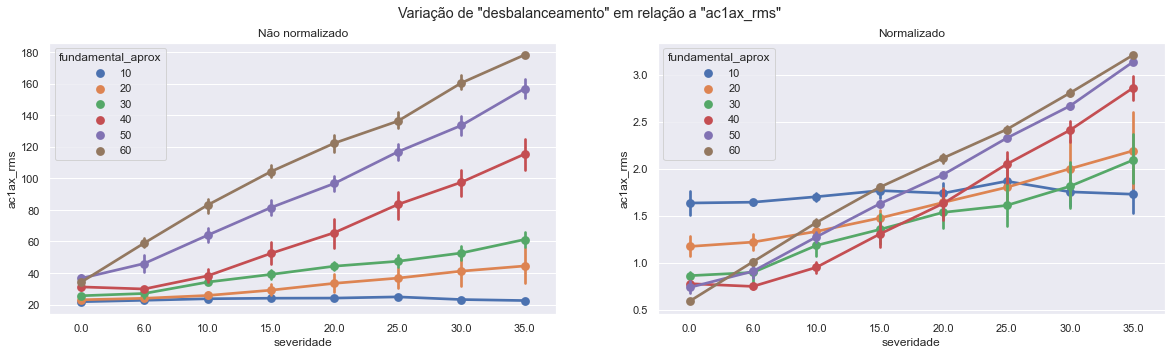

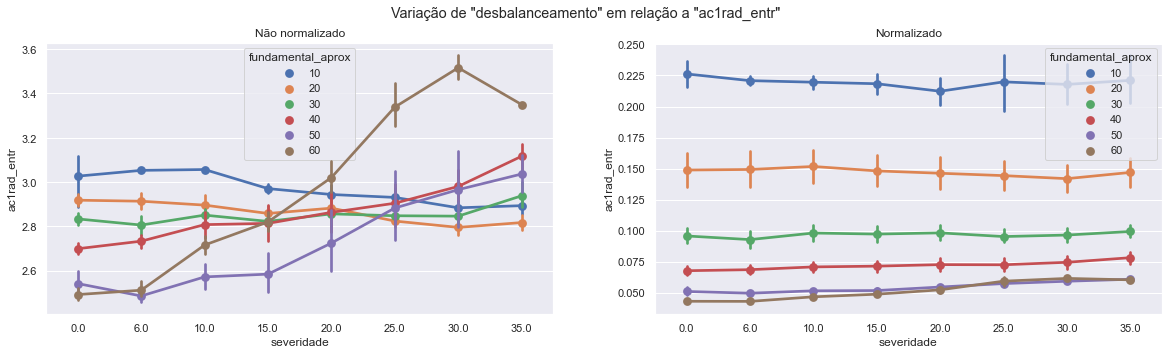

In [13]:
aux.plot_detailed_comparisson('ac1ax_rms', 'desbalanceamento', df_desbal, df_desbal_norm)
aux.plot_detailed_comparisson('ac1rad_entr', 'desbalanceamento', df_desbal, df_desbal_norm)

## Desalinhamento vertical

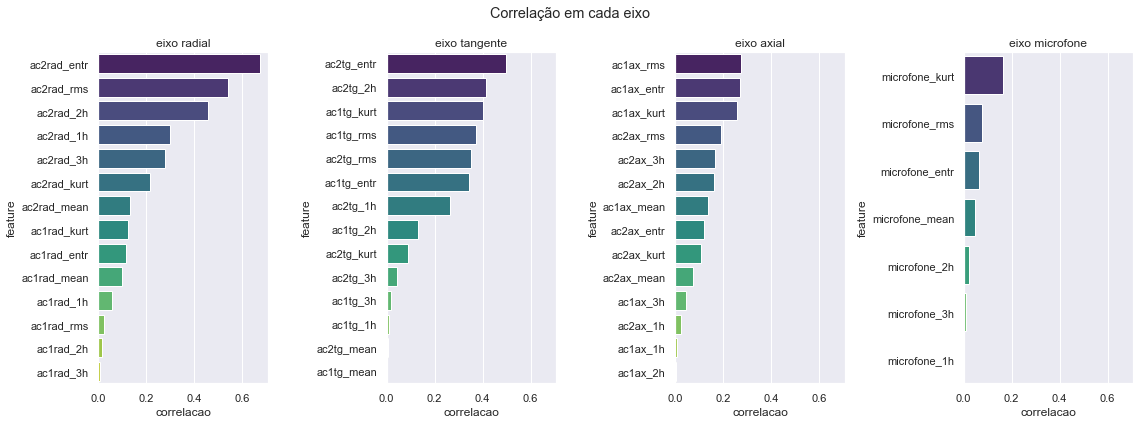

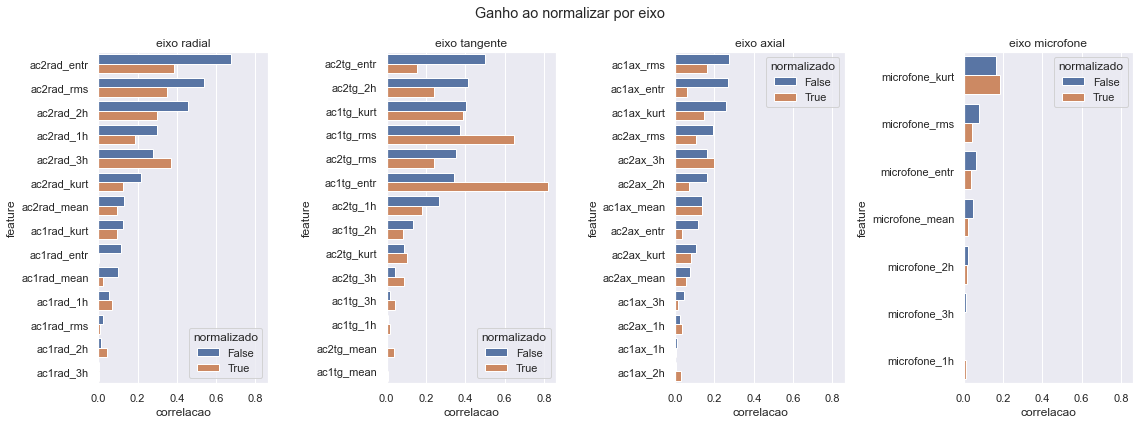

In [14]:
corr_df = aux.gera_corr_df('desalinhamento_vertical', df_des_ve, df_des_ve_norm, feat_to_eixo, feat_to_type)

aux.plot_correlations(corr_df)

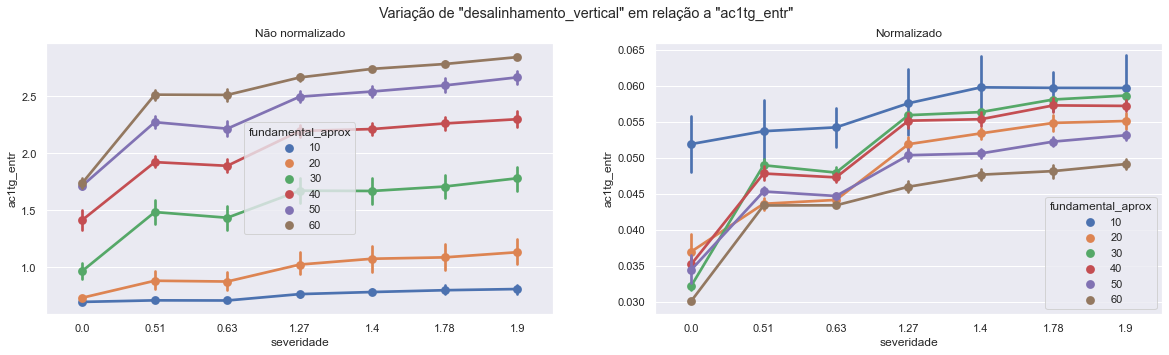

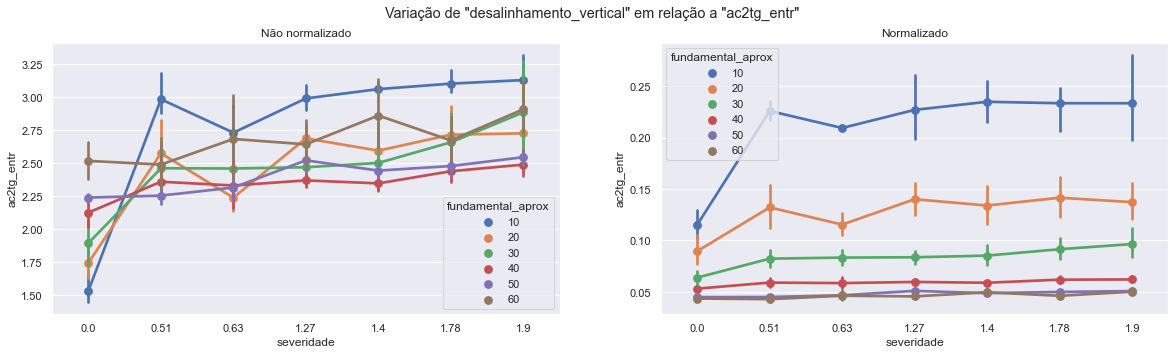

In [15]:
aux.plot_detailed_comparisson('ac1tg_entr', 'desalinhamento_vertical', df_des_ve, df_des_ve_norm)
aux.plot_detailed_comparisson('ac2tg_entr', 'desalinhamento_vertical', df_des_ve, df_des_ve_norm)

## Desalinhamento horizontal

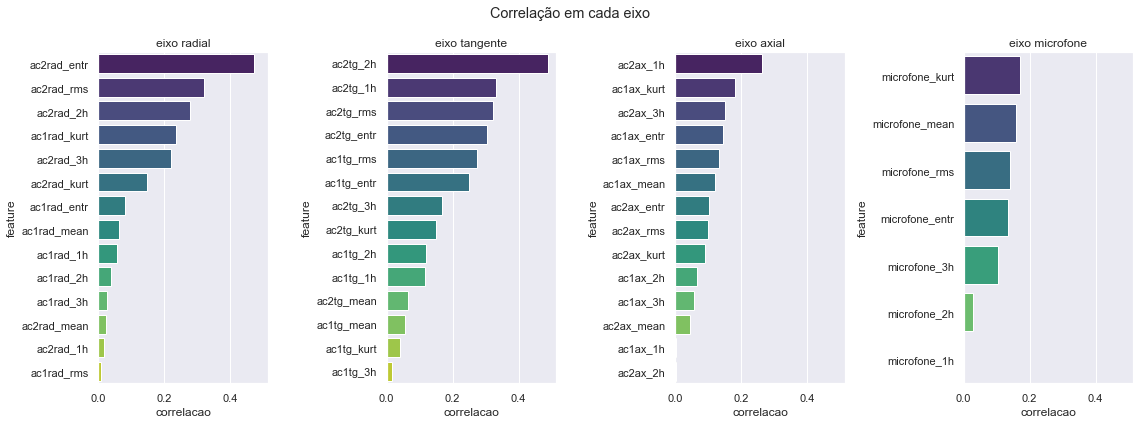

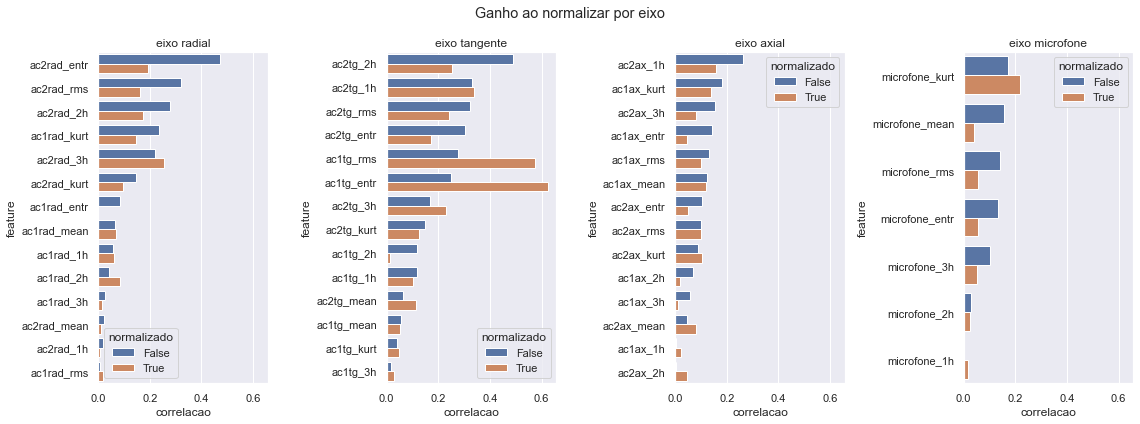

In [16]:
corr_df = aux.gera_corr_df('desalinhamento_horizontal', df_des_ho, df_des_ho_norm, feat_to_eixo, feat_to_type)

aux.plot_correlations(corr_df)

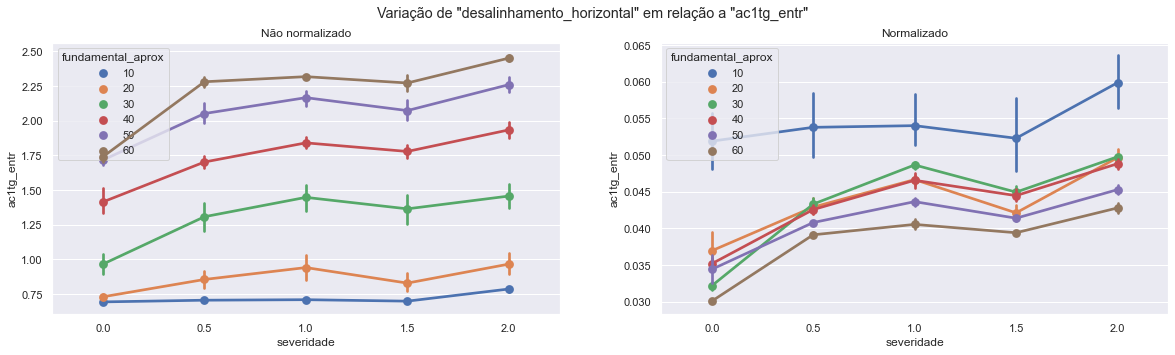

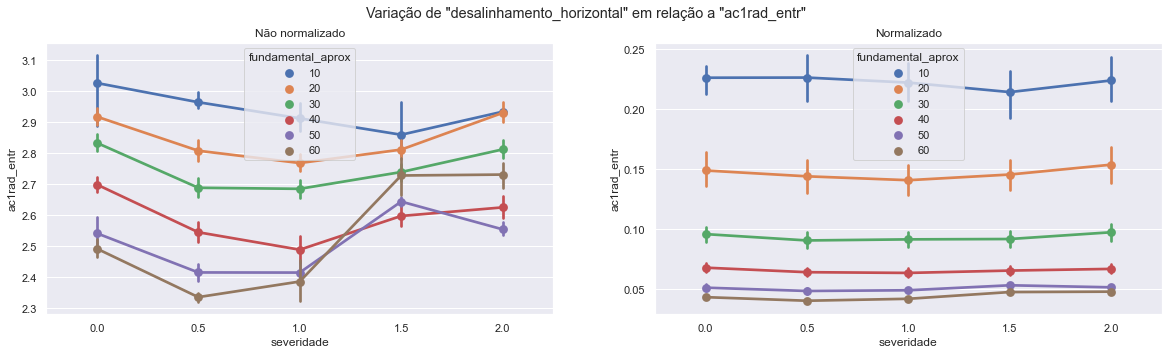

In [17]:
aux.plot_detailed_comparisson('ac1tg_entr', 'desalinhamento_horizontal', df_des_ho, df_des_ho_norm)
aux.plot_detailed_comparisson('ac1rad_entr', 'desalinhamento_horizontal', df_des_ho, df_des_ho_norm)

## Mudaças na correlação após normalização

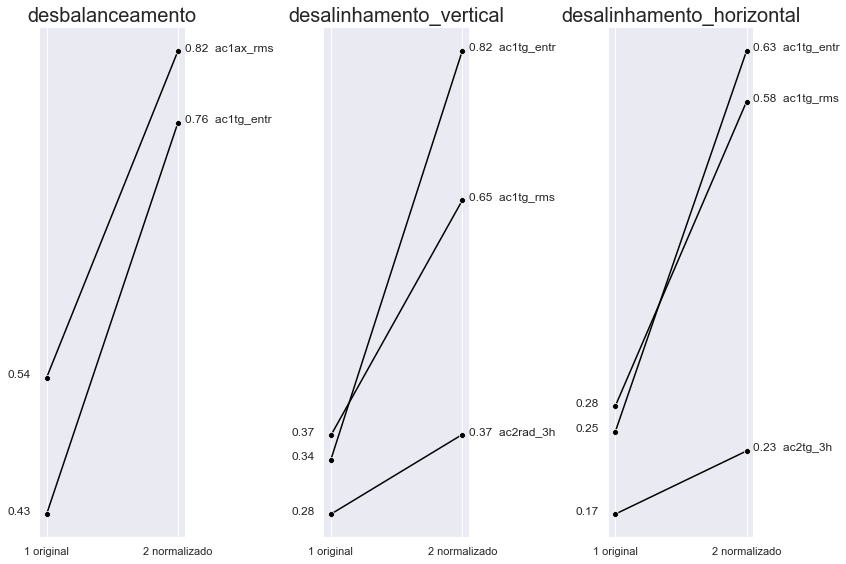

In [18]:
# plota maiores crescimentos 
fig, ax = plt.subplots(1, 3, figsize=(12, 8))

aux.plot_change_correlation('desbalanceamento',          df_desbal, df_desbal_norm, ax=ax[0], cut=2)
aux.plot_change_correlation('desalinhamento_vertical',   df_des_ve, df_des_ve_norm, ax=ax[1])
aux.plot_change_correlation('desalinhamento_horizontal', df_des_ho, df_des_ho_norm, ax=ax[2])

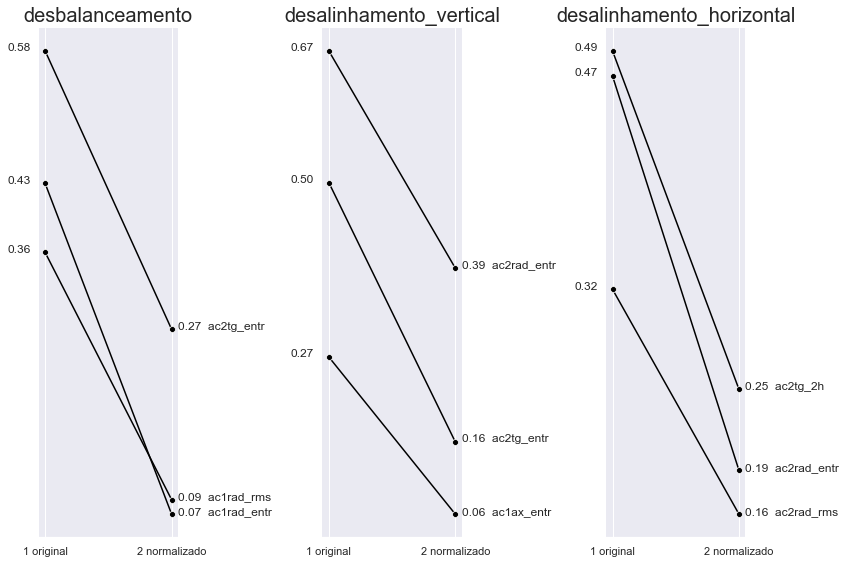

In [19]:
# plota maiores decrescimentos
fig, ax = plt.subplots(1, 3, figsize=(12, 8))

aux.plot_change_correlation('desbalanceamento',          df_desbal, df_desbal_norm, decrescente=True, ax=ax[0])
aux.plot_change_correlation('desalinhamento_vertical',   df_des_ve, df_des_ve_norm, decrescente=True, ax=ax[1])
aux.plot_change_correlation('desalinhamento_horizontal', df_des_ho, df_des_ho_norm, decrescente=True, ax=ax[2])